In [166]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

from sklearn.preprocessing import StandardScaler

pd.set_option('max_columns', None)
sns.set_theme(style="ticks")

# Linear Regression Model

In order to test the relevance of the selected features over the win percentage in NBA's regular season, I built and evaluated a multivariate linear regression model. In this notebook, I start by loading a CSV file with all the features extracted from the raw datasets in the `data_collection` and `data_cleaning_feature_engineering` notebooks and dropping the `Team_ID`, `TEAM_NAME`, and `YEAR` variables, leaving only the features potentially relevant to the model.

In [167]:
all_teams_full = pd.read_csv('all_teams_full_cleaned.csv')

In [168]:
all_features = all_teams_full.drop(columns=['TEAM_ID', 'TEAM_NAME', 'YEAR'])

In [169]:
all_features

,WIN_PCT,FG_PCT,REB,AST_TOV_RAT,PTS,OPP_PPG,HOME_WIN_PCT,PLAYOFF,TOP3_PPG,TOP3_P10,OFF_BENCH_PPG,BENCH_P30
0,0.439,0.471,44.5,1.514793,108.6,111.3,0.487805,1,18.032740,1,34.951220,1
1,0.354,0.480,43.2,1.465116,107.8,110.6,0.390244,0,18.894844,1,28.853659,0
2,0.378,0.470,44.8,1.182741,104.4,108.2,0.609756,0,17.705386,1,31.109756,1
3,0.512,0.490,40.3,1.440000,104.5,103.7,0.756098,1,16.714243,1,27.926829,0
4,0.695,0.502,42.8,1.714286,108.8,101.2,0.902439,1,18.791115,1,28.060976,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0.622,0.471,47.8,1.805369,115.2,112.5,0.756098,1,20.830769,1,23.475610,0
1106,0.589,0.468,45.4,1.816901,110.7,108.4,0.885714,1,19.672070,1,37.109756,1
1107,0.681,0.476,45.1,1.645833,113.6,108.1,0.805556,1,20.753404,1,38.341463,1
1108,0.622,0.466,42.3,1.896000,109.9,107.3,0.585366,1,21.757569,1,28.048780,0


### Field Definitions

`WIN_PCT`:       Wining percentage
`FG_PCT`:        Field Goal Percentage
`REB`:           Number of Rebounds per Game
`AST_TOV_RAT`:   Assistance/Turnover Ratio
`PTS`:           Average Points Per Game
`OPP_PPG`:       Average Opponent Points Per Game
`HOME_WIN_PCT`:  Percentage of Home Games Won
`PLAYOFF`:       Whether a Tean Classified to Playoffs a Given Year
`TOP3_PPG`:      Average Points Per Game by the Top 3 Scorers
`TOP3_P10`:      Whether the Top 3 Scorers All Averaged at Least 10 Points
`OFF_BENCH_PPG`: Average Points Per Game Off-The-Bench
`BENCH_P30`:     Whether a Team Averaged 30 plus Points Off-The-Bench per Game

### Correlation Matrix

Next is a Pearson Correlation matrix that shows how correlated variables are with each other. The most relevant row is the first, where we can assess the correlation between the variable I'm trying to predict and all the others. It's noticeable that `TOP3_P10`, `OFF_BENCH_PPG`, and `BENCH_P30` are not linearly correlated to the win percentage, so I'm not using these.

The `PPG` and `OPP_PPG` variables are highly correlated among themselves, violating the multicolinearity assumption for regression models, so only `OPP_PPG` will be used. `FG_PCT` is also highly correlated to `TOP3_PPG`, so only `FG_PCT` will be used.

In addition to that, `HOME_WIN_PCT`, the most correlated variable, is not interesting as a predictor for wining percentage since it accounts for half of the games represented by it. The `PLAYOFF` variable is also not relevant for the sake of this model.

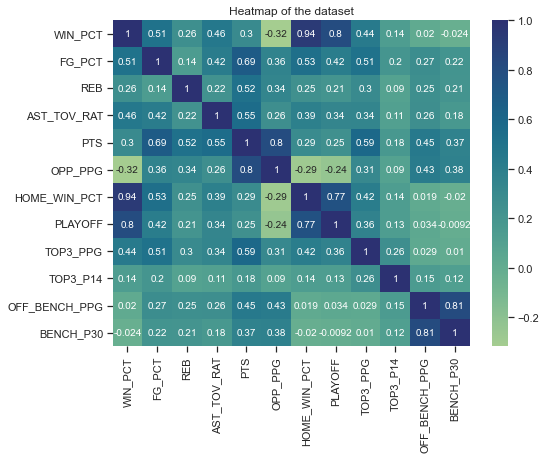

In [10]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    all_features.corr(), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

### Feature Selection

Finally, out of the original features, the selected ones to be used in the model are: `FG_PCT`, `REB`, `AST_TOV_RAT`, and `OPP_PPG`. I separated the data set into traning and testing sets using a `test_size` of 0.2, and StatsModels' Ordinary Least Squares model, `ols()`, was used to create the multivariate linear regression model.

In [155]:
# Separate data set into the predicted and predicting varibles
data_X = all_features[['FG_PCT', 'REB', 'AST_TOV_RAT', 'OPP_PPG']]
data_Y = all_features['WIN_PCT']



Since the variable the model is trying to predict and some of the predictors are in a vastly different scale, I'm rescaling the variables using StandarScaler. All predictors have a mean of zero and a standard deviation of one after scaling.

In [156]:
std_scaler = StandardScaler()
X_std_scaled = pd.DataFrame(std_scaler.fit_transform(data_X))
X_std_scaled = X_std_scaled.rename(columns={0: 'FG_PCT', 1:'REB', 2:'AST_TOV_RAT', 3:'OPP_PPG'})
X_std_scaled.index = data_X.index

In [157]:
# Use train_test_split to create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_std_scaled, data_Y, 
                                                    test_size = 0.2, random_state = 7)

In [158]:
# Write out OLS formula as a string
ols_formula = "WIN_PCT ~ FG_PCT + REB + AST_TOV_RAT + OPP_PPG"

# Create OLS dataframe
ols_data = pd.concat([X_train, y_train], axis = 1)

# Create OLS object and fit the model
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()

# Get model results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                WIN_PCT   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     732.6
Date:                Thu, 08 Feb 2024   Prob (F-statistic):          1.04e-278
Time:                        15:52:05   Log-Likelihood:                 1058.8
No. Observations:                 888   AIC:                            -2108.
Df Residuals:                     883   BIC:                            -2084.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5004      0.002    202.441      0.000       0.496       0.505
FG_PCT          0.0873      0.003     30.194      0.000       0.082       0.093
REB             0.0557      0.003     20.812      0.000       0.050       0.061
AST_TOV_RAT     0.0497      0.003     18.119      0.000       0.044       0.055
OPP_PPG        -0.1115      0.003    -39.615      0.000      -0.117      -0.106
==============================================================================
Omnibus:                       25.694   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.351
Skew:                           0.291   Prob(JB):                     2.11e-08
Kurtosis:                       3.785   Cond. No.                         1.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Results

The resulting model has an adjusted R-Squared value of 0.767, which means the predictor variables account for 76.7% of the variation in the predicted variable. Since the data was scaled to have a mean of zero and a standard deviation of one, the coefficients will be refering to one standard deviation unit in the predictor. The standard deviation for each variable is in the table below.

The coeficients read as the following:
- `FG_PCT`: For each 1.9% increase in the Field Goal Percentage, the Wining Rate is expected to increase in 8.7%
- `REB`: For each 2.13 Rebounds Per Game increase, the Wining Rate is expected to increase in 5.5%
- `AST_TOV_RAT`: For each 0.2 increase in the assistance/turnover ratio, the Wining Rate is expected to increase in 4.9%
- `OPP_PPG`: For each 7.4 Opponent Points Per Game increase, the Wining Rate is expected to decrease in 11.1%

In [165]:
# Get standard deviation values from the standardscaler object

original_std_devs = pd.DataFrame(std_scaler.scale_)
original_std_devs = original_std_devs.rename(index={0: 'FG_PCT', 1:'REB', 2:'AST_TOV_RAT', 3:'OPP_PPG', 4:'TOP3_PPG'}, columns={0:'Standard Deviation'})
original_std_devs

,Standard Deviation
FG_PCT,0.019638
REB,2.138948
AST_TOV_RAT,0.207024
OPP_PPG,7.403267


### Model Assessment

Checking for linear regression models assumptions:
- Linear relationship
- Multivariate Normality
- No Multicolinearity
- Homoscedasticity
- Normaly Distributed Residuals

#### Linear Relationship, Multivariate Normality, and No Multicolinearity

The chart below shows a scatterplot between each pair of variables and a histogram for each variable. From this chart we can confirm the first three linear regression model assumptions:
1) The predictor variables are linearly correlated to the predicted variable and have weak to moderate correlation.
2) The predictor variables are not correlated to each other.
3) Each of the predictor variables follows a normal distribution.

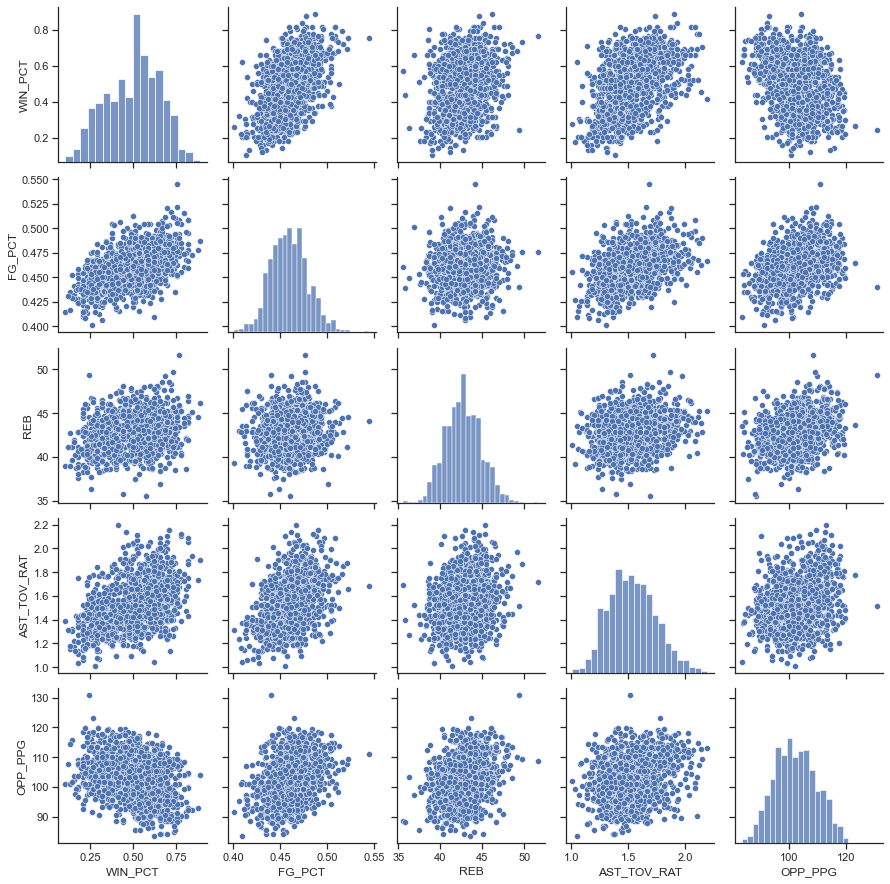

In [149]:
fig = sns.pairplot(all_features[['WIN_PCT', 'FG_PCT', 'REB','AST_TOV_RAT', 'OPP_PPG']])
plt.show()

#### Homoscedasticity, Normal Distribution of Residuals

The following charts account for the other model assumptions:
1) Homoscedasticity: the residuals are randomly distributed.
2) The residuals follow a normal distribution.

In [150]:
fitted_values = model.predict(X_test)
residuals = fitted_values - y_test

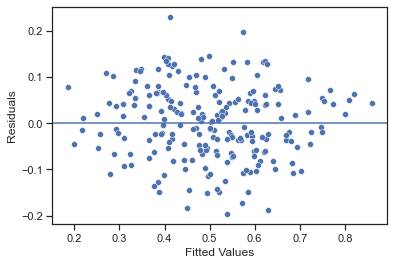

In [151]:
fig = sns.scatterplot(x=fitted_values, y=residuals)
fig.axhline(0)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
plt.show()

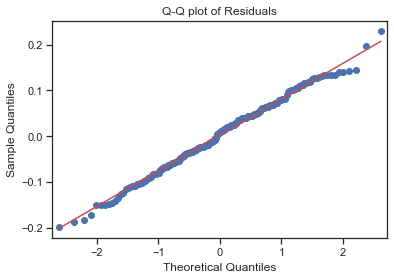

In [152]:
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title("Q-Q plot of Residuals")
plt.show()

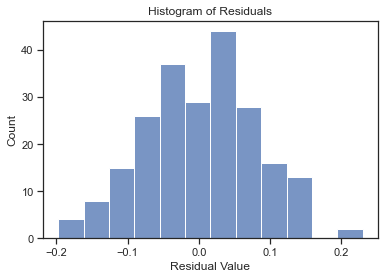

In [153]:
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()